In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from tqdm import tqdm

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [26]:
!nvidia-smi

Thu May 23 19:59:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0              33W /  70W |   6523MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [27]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# Directories
data_dir = '/content/drive/MyDrive/Colab/112-2-DLA/final/data'
data_dir

'/content/drive/MyDrive/Colab/112-2-DLA/final/data'

In [29]:
config = {
    'train_ratio': 0.8,
    'valid_ratio': 0.1,
    'test_ratio': 0.1,
    'batch_size': 64,
    'num_epochs': 30,
}

In [30]:
# Data transforms
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = datasets.ImageFolder(data_dir, data_transforms)
full_dataset

Dataset ImageFolder
    Number of datapoints: 5250
    Root location: /content/drive/MyDrive/Colab/112-2-DLA/final/data
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [31]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from torch.utils.data import DataLoader, Subset

# Assuming full_dataset is a torchvision dataset or similar
targets = np.array(full_dataset.targets)  # Extract the target labels

# Define the split ratios
train_ratio, val_ratio = config['train_ratio'], config['valid_ratio']
test_ratio = 1 - train_ratio - val_ratio

# First stratified split to get training set and temporary set (validation + test)
sss_train = StratifiedShuffleSplit(n_splits=1, test_size=1 - train_ratio, random_state=42)
train_idx, temp_idx = next(sss_train.split(np.zeros(len(targets)), targets))

# Extract the targets for the temporary set
temp_targets = targets[temp_idx]

# Second stratified split to split the temporary set into validation and test sets
sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio/(val_ratio + test_ratio), random_state=620)
val_idx, test_idx = next(sss_val_test.split(np.zeros(len(temp_targets)), temp_targets))

# Map the indices back to the original dataset
val_idx = temp_idx[val_idx]
test_idx = temp_idx[test_idx]

# Create the Subsets
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2)

# Dataloaders and dataset sizes
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Class names
class_names = full_dataset.classes
class_names

['battery',
 'glass',
 'metal',
 'normal plastic',
 'paper',
 'paper container',
 'plastic bottle']

In [32]:
# Model
from torchvision.models import ResNet50_Weights

model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [33]:
def train_model(model, criterion, optimizer, num_epochs=25):
    best_model_wts = model.state_dict()
    best_val_acc = 0.0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        # print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase} Epoch {epoch}/{num_epochs - 1}', leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += labels.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects.double() / total_samples

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.cpu().item())  # Ensure it's on CPU and convert to item
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.cpu().item())  # Ensure it's on CPU and convert to item
                if epoch_acc > best_val_acc:
                    best_val_acc = epoch_acc
                    best_model_wts = model.state_dict()

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    print(f'Best val Acc: {best_val_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accs, val_accs

# Train model
model, train_losses, val_losses, train_accs, val_accs = train_model(model, criterion, optimizer, num_epochs=config['num_epochs'])


Epoch 0/29


train Loss: 1.6954 Acc: 0.4929


val Loss: 1.3680 Acc: 0.6819
Epoch 1/29


train Loss: 1.0952 Acc: 0.7407


val Loss: 0.8544 Acc: 0.8000
Epoch 2/29


train Loss: 0.7574 Acc: 0.7926


val Loss: 0.6465 Acc: 0.8267
Epoch 3/29


train Loss: 0.5782 Acc: 0.8362


val Loss: 0.5057 Acc: 0.8629
Epoch 4/29


train Loss: 0.4928 Acc: 0.8467


val Loss: 0.4249 Acc: 0.8629
Epoch 5/29


train Loss: 0.4143 Acc: 0.8717


val Loss: 0.3620 Acc: 0.8914
Epoch 6/29


train Loss: 0.3759 Acc: 0.8843


val Loss: 0.3598 Acc: 0.8838
Epoch 7/29


train Loss: 0.3365 Acc: 0.8940


val Loss: 0.3300 Acc: 0.9048
Epoch 8/29


train Loss: 0.3287 Acc: 0.8960


val Loss: 0.2830 Acc: 0.9181
Epoch 9/29


train Loss: 0.2818 Acc: 0.9131


val Loss: 0.3212 Acc: 0.9067
Epoch 10/29


train Loss: 0.2804 Acc: 0.9148


val Loss: 0.2871 Acc: 0.9010
Epoch 11/29


train Loss: 0.2468 Acc: 0.9229


val Loss: 0.2973 Acc: 0.9048
Epoch 12/29


train Loss: 0.2374 Acc: 0.9229


val Loss: 0.2225 Acc: 0.9124
Epoch 13/29


train Loss: 0.2213 Acc: 0.9271


val Loss: 0.2482 Acc: 0.9181
Epoch 14/29


train Loss: 0.2058 Acc: 0.9355


val Loss: 0.2024 Acc: 0.9448
Epoch 15/29


train Loss: 0.1957 Acc: 0.9421


val Loss: 0.2066 Acc: 0.9371
Epoch 16/29


train Loss: 0.1902 Acc: 0.9407


val Loss: 0.2190 Acc: 0.9200
Epoch 17/29


train Loss: 0.1841 Acc: 0.9450


val Loss: 0.2014 Acc: 0.9371
Epoch 18/29


train Loss: 0.1769 Acc: 0.9417


val Loss: 0.1854 Acc: 0.9295
Epoch 19/29


train Loss: 0.1658 Acc: 0.9457


val Loss: 0.2085 Acc: 0.9333
Epoch 20/29


train Loss: 0.1576 Acc: 0.9545


val Loss: 0.2275 Acc: 0.9219
Epoch 21/29


train Loss: 0.1638 Acc: 0.9479


val Loss: 0.1877 Acc: 0.9429
Epoch 22/29


train Loss: 0.1542 Acc: 0.9521


val Loss: 0.1823 Acc: 0.9390
Epoch 23/29


train Loss: 0.1405 Acc: 0.9564


val Loss: 0.1846 Acc: 0.9448
Epoch 24/29


train Loss: 0.1435 Acc: 0.9562


val Loss: 0.1648 Acc: 0.9448
Epoch 25/29


train Loss: 0.1356 Acc: 0.9588


val Loss: 0.1789 Acc: 0.9448
Epoch 26/29


train Loss: 0.1320 Acc: 0.9576


val Loss: 0.1790 Acc: 0.9371
Epoch 27/29


train Loss: 0.1238 Acc: 0.9640


val Loss: 0.1635 Acc: 0.9429
Epoch 28/29


train Loss: 0.1149 Acc: 0.9638


val Loss: 0.1505 Acc: 0.9505
Epoch 29/29


train Loss: 0.1272 Acc: 0.9574


val Loss: 0.1611 Acc: 0.9467
Best val Acc: 0.9505


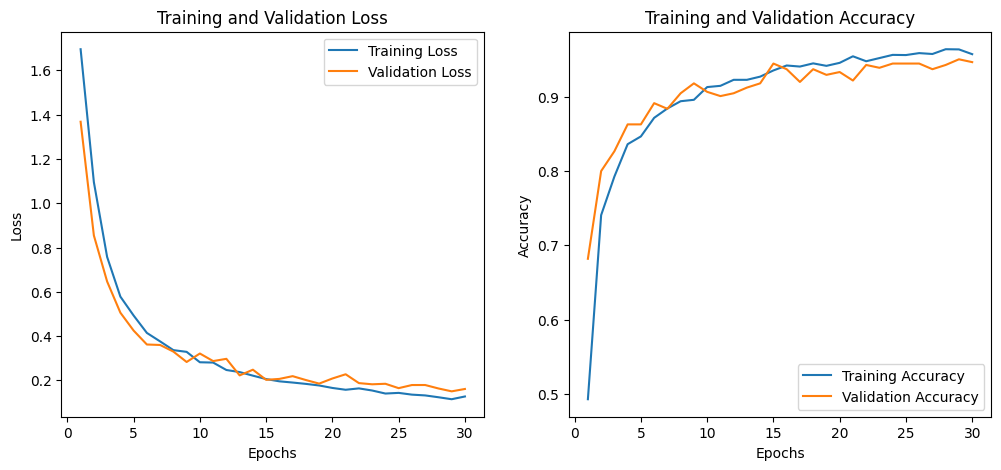

In [34]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Training Accuracy')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


Test Loss: 0.2067 Acc: 0.9371


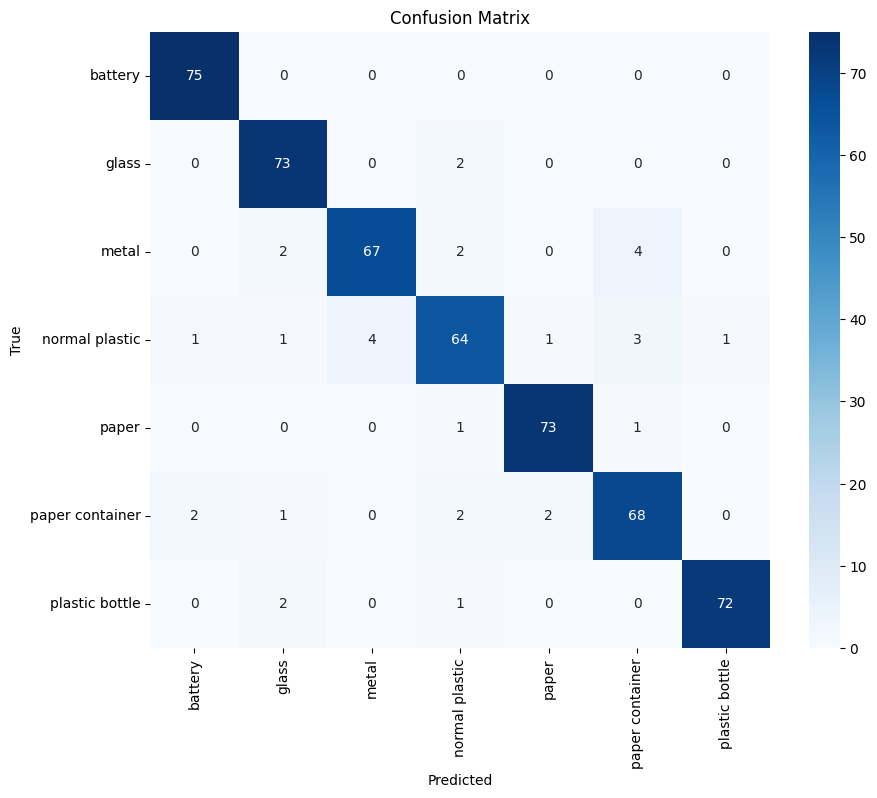


Classification Report:
                 precision    recall  f1-score   support

        battery       0.96      1.00      0.98        75
          glass       0.92      0.97      0.95        75
          metal       0.94      0.89      0.92        75
 normal plastic       0.89      0.85      0.87        75
          paper       0.96      0.97      0.97        75
paper container       0.89      0.91      0.90        75
 plastic bottle       0.99      0.96      0.97        75

       accuracy                           0.94       525
      macro avg       0.94      0.94      0.94       525
   weighted avg       0.94      0.94      0.94       525

Weighted F1 Score: 0.9368
Macro-average F1 Score: 0.9368
Micro-average F1 Score: 0.9371


In [35]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns

# Evaluate model on the test set
def evaluate_model(model, dataloader):
    model.eval()
    running_corrects = 0
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating', leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    loss = running_loss / len(dataloader.dataset)
    acc = running_corrects.double() / len(dataloader.dataset)

    print(f'Test Loss: {loss:.4f} Acc: {acc:.4f}')

    return all_labels, all_preds

# Evaluate on the test set
all_labels, all_preds = evaluate_model(model, dataloaders['test'])

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(all_labels, all_preds, target_names=class_names)
print('\nClassification Report:')
print(class_report)

# F1 Score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'Weighted F1 Score: {f1:.4f}')

# Macro- and Micro-average F1 Scores
macro_f1 = f1_score(all_labels, all_preds, average='macro')
micro_f1 = f1_score(all_labels, all_preds, average='micro')
print(f'Macro-average F1 Score: {macro_f1:.4f}')
print(f'Micro-average F1 Score: {micro_f1:.4f}')

In [36]:
# Save model
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab/112-2-DLA/final/resnet50.ckpt')